##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from zipfile import ZipFile
file_name = "data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [1]:
# check image labels
import os
image_path = "/content/data"
#print(image_path)
labels = []
for i in os.listdir(image_path):
  if os.path.isdir(os.path.join(image_path, i)):
    labels.append(i)
print(labels)

['melanoma', 'psoriasis', 'no_lesions', 'dermatofibroma', 'acne']


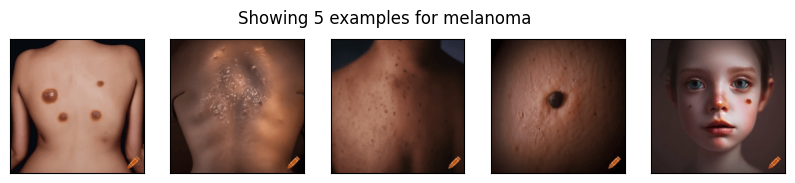

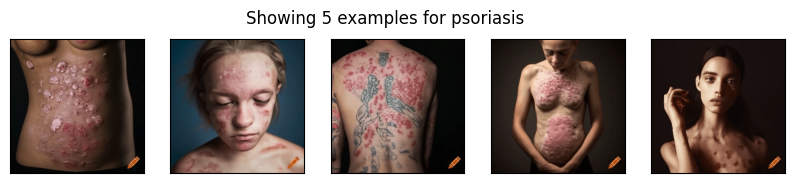

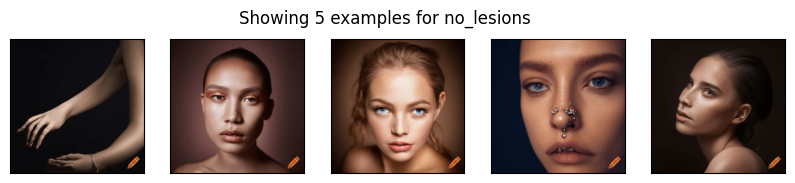

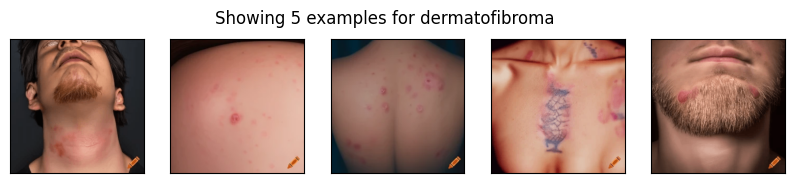

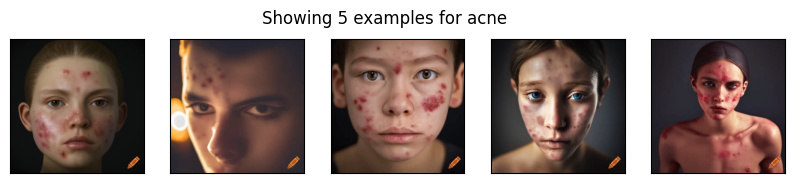

In [2]:
import matplotlib.pyplot as plt

NUM_EXAMPLES = 5
IMAGES_PATH = "data"

# Get the list of labels from the list of folder names.
labels = []
for i in os.listdir(IMAGES_PATH):
  if os.path.isdir(os.path.join(IMAGES_PATH, i)):
    labels.append(i)

# Show the images.
for label in labels:
  label_dir = os.path.join(IMAGES_PATH, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

## Making a New Model



In [3]:
!pip install -q mediapipe-model-maker

In [4]:
# Import the necessary modules.
from mediapipe_model_maker import image_classifier

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Split the archive into training, validation and test dataset.
data = image_classifier.Dataset.from_folder("data")
train_data, remaining_data = data.split(0.8)
test_data, validation_data = remaining_data.split(0.5)

In [6]:
# Retrain model
#spec = image_classifier.SupportedModels.MOBILENET_V2
spec = image_classifier.SupportedModels.EFFICIENTNET_LITE0
#spec = image_classifier.SupportedModels.EFFICIENTNET_LITE2
#spec = image_classifier.SupportedModels.EFFICIENTNET_LITE4
hparams = image_classifier.HParams(export_dir="exported_model")
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)

In [7]:
# Run retraining
model = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = validation_data,
    options=options,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3419429 (13.04 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 3413024 (13.02 MB)
_________________________________________________________________
None
Epoch 1/10
200/200 [==============================] - 23s 103ms/step - loss: 1.8711 - accuracy: 0.1850 - val_loss: 1.8628 - val_accuracy: 0.1400
Epoch 2/10
200/200 [==============================] - 20s 99ms/step - loss: 1.7480 - accuracy: 0.2125 - val_loss: 1.6236 - val_a

In [8]:
# only loss and accuracy available here
loss, acc = model.evaluate(test_data)
print(f'Test loss:{loss}, Test accuracy:{acc}')

2/2 [==============================] - 2s 582ms/step - loss: 0.8979 - accuracy: 0.7600
Test loss:0.8979112505912781, Test accuracy:0.7599999904632568


In [9]:
# Export the model bundle.
model.export_model()

# Rename the file to be more descriptive.
!mv exported_model/model.tflite skin_lesion_classifier.tflite

In [10]:
from google.colab import files
files.download("exported_model/skin_lesion_classifier.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>